In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)
dog_df = pd.read_csv(path + '/dogs.csv')

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


In [23]:
# libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [24]:
image_path = path + '/' + dog_df['filepaths'].iloc[0]

print(image_path)

/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train/Afghan/001.jpg


In [25]:
# get dataframes of dogs by train/test/validation

train_df = dog_df[dog_df.iloc[:, 2] == "train"].copy()
valid_df = dog_df[dog_df.iloc[:, 2] == "valid"].copy()
test_df = dog_df[dog_df.iloc[:, 2] == "test"].copy()
train_df.head()

# get folder paths of dogs by train/test/validation

train_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train'
valid_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/valid'
test_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test'

Below is preprocessing + resnet50 model attempt

In [26]:
# considered grayscale but read online somewhere that color is helpful for breed identification
# preprocessing tasks

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Apply zoom transformations
    horizontal_flip=True       # Flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/validation

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),    # Resize images
    batch_size=32,             # Adjust as needed based on your memory
    class_mode='categorical'   # Use 'binary' if you have only two classes
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


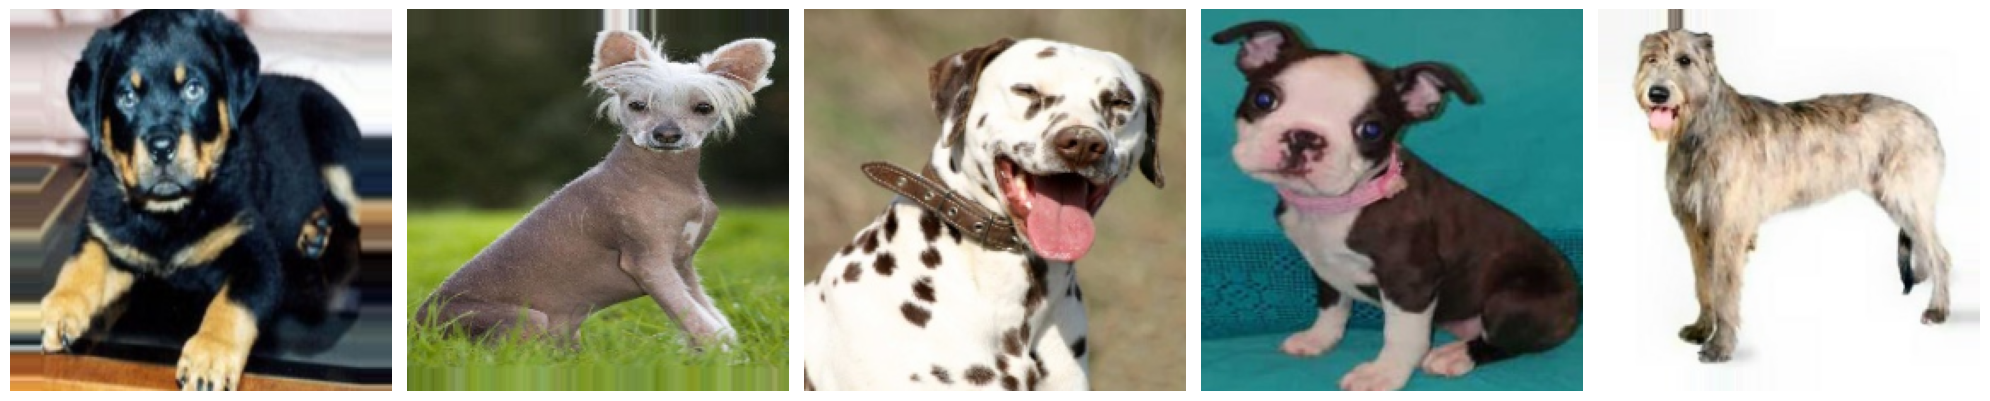

In [27]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


sample_training_images, _ = next(train_generator)
plot_images(sample_training_images[:5])

In [28]:
from tensorflow.keras.applications import ResNet50  # Or MobileNetV2, EfficientNetB0, etc.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# 1. Load the pre-trained model (without the top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False)

# 2. Create your own classifier
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Often used with pre-trained models
model.add(Dense(70, activation='softmax'))  # 120 for the number of dog breeds

# 3. Freeze the base model layers (optional, but common for initial training)
base_model.trainable = False

# 4. Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Train the model
model.fit(train_generator,epochs=10, validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 1680s 7s/step - accuracy: 0.0234 - loss: 4.3277 - val_accuracy: 0.0300 - val_loss: 4.2476
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1674s 7s/step - accuracy: 0.0368 - loss: 4.1755 - val_accuracy: 0.0329 - val_loss: 4.1518
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1672s 7s/step - accuracy: 0.0438 - loss: 4.1129 - val_accuracy: 0.0486 - val_loss: 4.1386
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1693s 7s/step - accuracy: 0.0557 - loss: 4.0784 - val_accuracy: 0.0414 - val_loss: 4.0842
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1713s 7s/step - accuracy: 0.0550 - loss: 4.0325 - val_accuracy: 0.0571 - val_loss: 4.0612
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1683s 7s/step - accuracy: 0.0563 - loss: 4.0232 - val_accuracy: 0.0657 - val_loss: 4.0393
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.0577 - loss: 3.9943 - val_accuracy: 0.0586 - val_loss: 4.0271
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1670s 7s/step - accuracy: 0.0659 - loss: 3.9679 - val_accurac

Below is CNN architecture attempt

In [29]:
!pip install tensorflow.keras.layers
!pip install tensorflow.keras.optimizers
!pip install keras.models
!pip install keras.layers
!pip install keras.utils
!pip install keras.preprocessing.image

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers
ERROR: Could not find a version that satisfies the requirement tensorflow.keras.optimizers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.optimizers
ERROR: Could not find a version that satisfies the requirement keras.layers (from versions: none)
ERROR: No matching distribution found for keras.layers
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.image


In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input , BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale, create directory paths
datagen = ImageDataGenerator(rescale=1./255,)

train_dir = path + '/train/'
test_dir = path + '/test/'
val_dir = path + '/valid/'

In [32]:
train_dataset = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)

# Load testing data
test_dataset = datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)
val_dataset = datagen.flow_from_directory(
    val_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)
num_classes = 70

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [33]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(70, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

In [34]:
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset , batch_size=32 , verbose=1)


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 675s 5s/step - accuracy: 0.0321 - loss: 6.5642 - val_accuracy: 0.0143 - val_loss: 4.2488
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 672s 5s/step - accuracy: 0.0722 - loss: 4.1465 - val_accuracy: 0.0171 - val_loss: 4.2339
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.1064 - loss: 3.8749 - val_accuracy: 0.0329 - val_loss: 4.6576
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 680s 5s/step - accuracy: 0.1280 - loss: 3.6855 - val_accuracy: 0.0600 - val_loss: 4.0634
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 665s 5s/step - accuracy: 0.1637 - loss: 3.4898 - val_accuracy: 0.0657 - val_loss: 4.0671
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 691s 5s/step - accuracy: 0.1884 - loss: 3.3577 - val_accuracy: 0.1329 - val_loss: 4.0805
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 668s 5s/step - accuracy: 0.2189 - loss: 3.1478 - val_accuracy: 0.1414 - val_loss: 3.9543
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 661s 5s/step - accuracy: 0.2505 - loss: 2.9633 - val_accu

Below is graph data

NameError: name 'data' is not defined

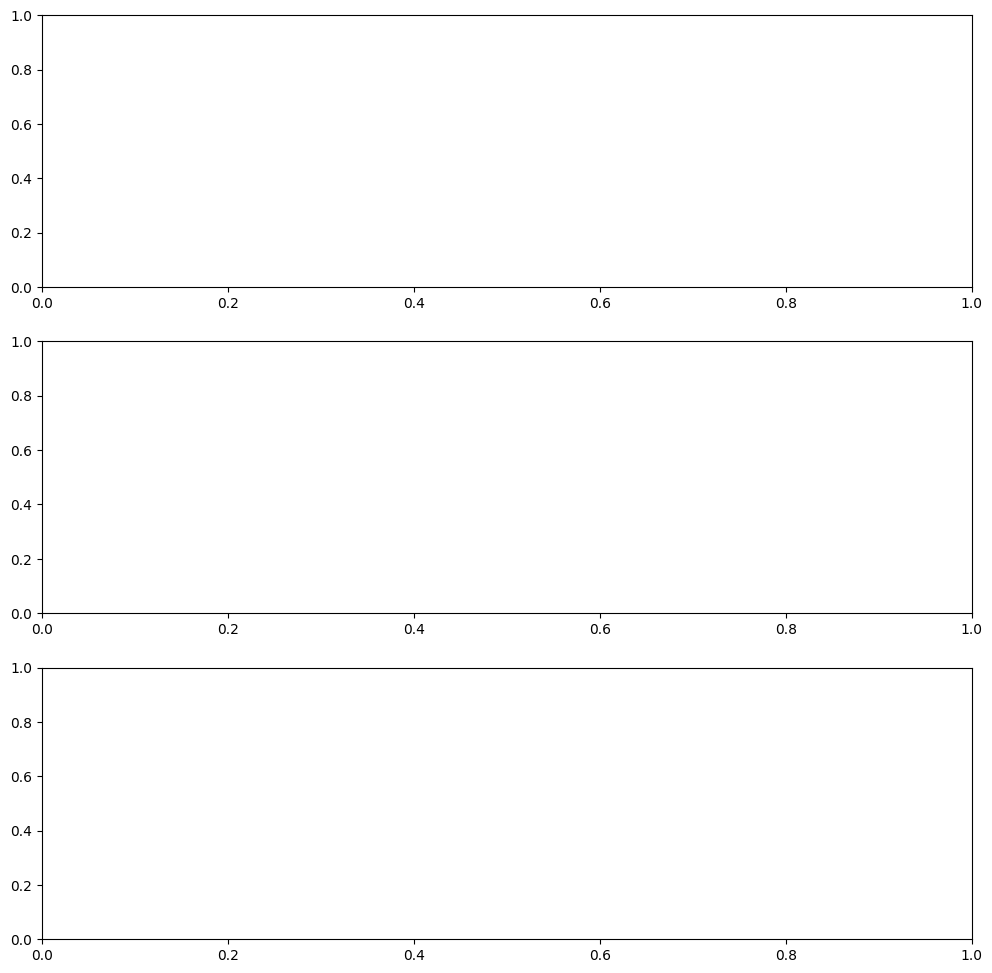

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with three subplots (one for each dataset)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # Adjust figsize as needed

# Plot histogram for the 'train' dataset
sns.countplot(x='labels', data=data[data['data set'] == 'train'], ax=axes[0])
axes[0].set_title('Distribution of Breeds in Train Dataset')
axes[0].set_xlabel('Dog Breed')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Plot histogram for the 'test' dataset
sns.countplot(x='labels', data=data[data['data set'] == 'test'], ax=axes[1])
axes[1].set_title('Distribution of Breeds in Test Dataset')
axes[1].set_xlabel('Dog Breed')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

# Plot histogram for the 'valid' dataset
sns.countplot(x='labels', data=data[data['data set'] == 'valid'], ax=axes[2])
axes[2].set_title('Distribution of Breeds in Validation Dataset')
axes[2].set_xlabel('Dog Breed')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()